In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt

from operator import itemgetter  

from sklearn.metrics import plot_confusion_matrix

import os

# Evaluation

## Last-layer features

In [59]:
last_features_class1_path = "./output/1-2_icu_18feat.csv"
last_features_class2_path = "./output/1-2_not_icu_18feat.csv"

In [60]:
last_features_class1 = pd.read_csv(last_features_class1_path)
last_features_class1 = last_features_class1.iloc[:,1:].to_numpy()

print(last_features_class1.shape)

(35, 18)


In [61]:
last_features_class2 = pd.read_csv(last_features_class2_path)
last_features_class2 = last_features_class2.iloc[:,1:].to_numpy()

print(last_features_class2.shape)

(65, 18)


In [62]:
#concatenate
last_features = np.concatenate((last_features_class1, last_features_class2), axis=0)
print(last_features.shape)

#normalize
last_features_norm = (last_features - last_features.mean(axis=0)) / last_features.std(axis=0)  
print(last_features_norm.shape)

(100, 18)
(100, 18)


In [63]:
feature_name_file_path = './output/features_names.txt'

feature_names = []
with open(feature_name_file_path,'r') as f:
    for line in f:
        feature_names.append(str(line))
        
print(len(feature_names))
print(feature_names[0:5])

18
['Atelectasis\n', 'Cardiomegaly\n', 'Consolidation\n', 'Edema\n', 'Effusion\n']


In [97]:
Y = np.zeros((last_features.shape[0],))
Y[0:last_features_class1.shape[0],] = 1
Y.shape

(100,)

In [98]:
features = last_features_norm
features_names_ = feature_names

max_depth_tree = 3
min_samples_leaf = 10
clf_18 = tree.DecisionTreeClassifier(class_weight={0:1,1:1},max_depth=max_depth_tree, min_samples_leaf=min_samples_leaf)

#class_weight={0:10,1:1}

in_training_loss = True
train_test_ratio = 0.2

if in_training_loss:
    clf_18 = clf_18.fit(features, Y)
    y_pred = clf_18.predict(features)

    print(confusion_matrix(Y, y_pred))
    print(classification_report(Y, y_pred))

    feature_lst=[i for i in clf_18.tree_.feature if i != -2]

    print('features =', feature_lst)
    print('features name=', list(itemgetter(*feature_lst)(features_names_)))

else:
  X_train, X_test, y_train, y_test = \
  train_test_split(features, Y, test_size=train_test_ratio)

  clf_18 = clf_18.fit(X_train, y_train)
  y_pred = clf_18.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))



[[58  7]
 [11 24]]
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87        65
         1.0       0.77      0.69      0.73        35

    accuracy                           0.82       100
   macro avg       0.81      0.79      0.80       100
weighted avg       0.82      0.82      0.82       100

features = [4, 2, 16, 11, 15]
features name= ['Effusion\n', 'Consolidation\n', 'Pneumonia\n', 'Lung Lesion\n', 'Pleural_Thickening\n']


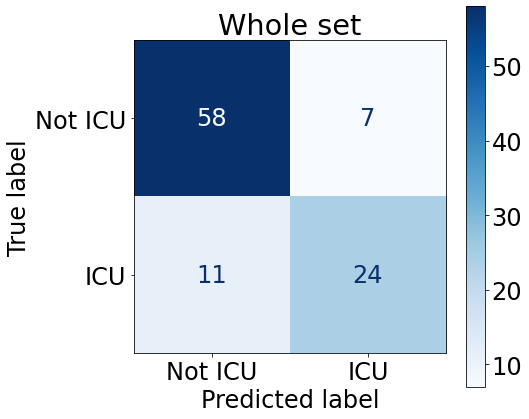

In [100]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 24})

disp = plot_confusion_matrix(clf_18, features, Y,
                             display_labels=['Not ICU','ICU'],
                             cmap=plt.cm.Blues,
                             ax=ax)
disp.ax_.set_title('Whole set')

label_font = {'size':'24'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);



[Text(659.4545454545455, 475.65000000000003, 'X[4] <= 0.741\ngini = 0.455\nsamples = 100.0%\nvalue = [0.65, 0.35]'),
 Text(405.8181818181818, 339.75, 'X[2] <= -0.091\ngini = 0.352\nsamples = 79.0%\nvalue = [0.772, 0.228]'),
 Text(202.9090909090909, 203.85000000000002, 'X[16] <= -0.582\ngini = 0.485\nsamples = 29.0%\nvalue = [0.586, 0.414]'),
 Text(101.45454545454545, 67.94999999999999, 'gini = 0.388\nsamples = 19.0%\nvalue = [0.737, 0.263]'),
 Text(304.3636363636364, 67.94999999999999, 'gini = 0.42\nsamples = 10.0%\nvalue = [0.3, 0.7]'),
 Text(608.7272727272727, 203.85000000000002, 'X[11] <= 0.644\ngini = 0.211\nsamples = 50.0%\nvalue = [0.88, 0.12]'),
 Text(507.27272727272725, 67.94999999999999, 'gini = 0.056\nsamples = 35.0%\nvalue = [0.971, 0.029]'),
 Text(710.1818181818181, 67.94999999999999, 'gini = 0.444\nsamples = 15.0%\nvalue = [0.667, 0.333]'),
 Text(913.0909090909091, 339.75, 'X[15] <= 1.017\ngini = 0.308\nsamples = 21.0%\nvalue = [0.19, 0.81]'),
 Text(811.6363636363636, 203.

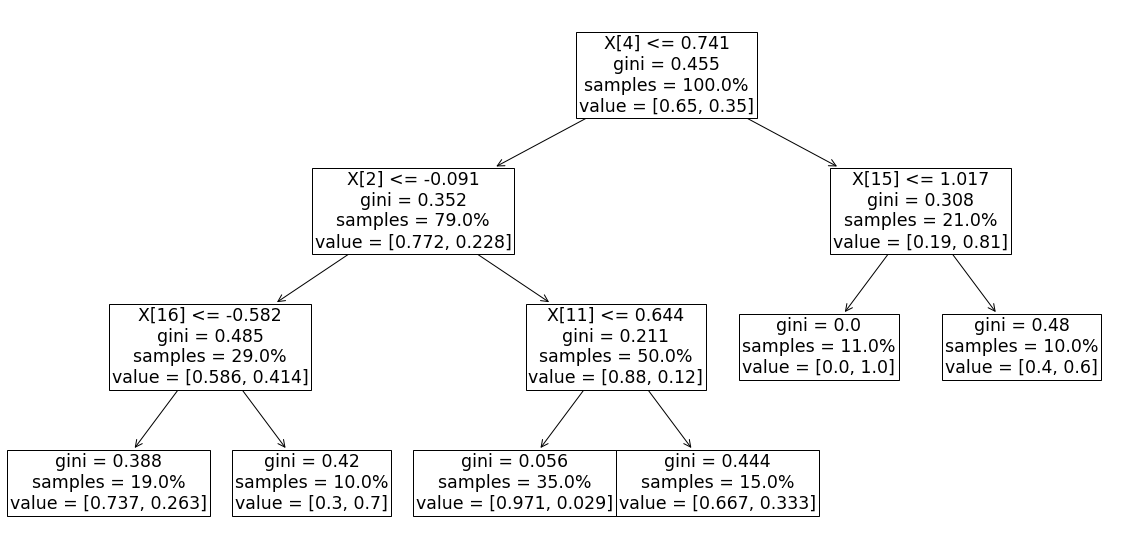

In [101]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf_18, proportion=True) 

### Cross-val

In [102]:
# cross-validation

from sklearn.model_selection import cross_val_score, cross_val_predict

cv_scores = cross_val_predict(clf_18, features, Y, cv=35)

print(confusion_matrix(Y, cv_scores))
print(classification_report(Y, cv_scores))

[[56  9]
 [18 17]]
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81        65
         1.0       0.65      0.49      0.56        35

    accuracy                           0.73       100
   macro avg       0.71      0.67      0.68       100
weighted avg       0.72      0.73      0.72       100



## Mid-layer features

In [74]:
mid_features_class1_path = "./output/1-2_icu_1024feat.csv"
mid_features_class2_path = "./output/1-2_not_icu_1024feat.csv"

In [75]:
mid_features_class1 = pd.read_csv(mid_features_class1_path)
mid_features_class1 = mid_features_class1.iloc[:,1:].to_numpy()

print(mid_features_class1.shape)

(35, 1024)


In [76]:
mid_features_class2 = pd.read_csv(mid_features_class2_path)
mid_features_class2 = mid_features_class2.iloc[:,1:].to_numpy()

print(mid_features_class2.shape)

(65, 1024)


In [77]:
# concatenate
mid_features = np.concatenate((mid_features_class1, mid_features_class2), axis=0)
print(mid_features.shape)

#normalize
mid_features_norm = (mid_features - mid_features.mean(axis=0)) / mid_features.std(axis=0)  
mid_features_norm[np.isnan(mid_features_norm)] = 0
print(mid_features_norm.shape)

(100, 1024)
(100, 1024)


/home/barth/anaconda3/envs/covid_test/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [78]:
features = mid_features_norm

max_depth_tree = 3
min_samples_leaf = 15
clf = tree.DecisionTreeClassifier(class_weight={0:1,1:1},max_depth=max_depth_tree, min_samples_leaf=min_samples_leaf)

in_training_loss = True
train_test_ratio = 0.2

if in_training_loss:
    clf = clf.fit(features, Y)
    y_pred = clf.predict(features)

    print(confusion_matrix(Y, y_pred))
    print(classification_report(Y, y_pred))

    feature_lst=[i for i in clf.tree_.feature if i != -2]
    print(len(feature_lst),'features')

else:
  X_train, X_test, y_train, y_test = \
  train_test_split(features, Y, test_size=train_test_ratio)

  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

[[65  0]
 [15 20]]
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90        65
         1.0       1.00      0.57      0.73        35

    accuracy                           0.85       100
   macro avg       0.91      0.79      0.81       100
weighted avg       0.88      0.85      0.84       100

4 features


[Text(558.0, 475.65000000000003, 'X[528] <= -0.519\ngini = 0.455\nsamples = 100.0%\nvalue = [0.65, 0.35]'),
 Text(279.0, 339.75, 'X[908] <= -0.164\ngini = 0.388\nsamples = 38.0%\nvalue = [0.263, 0.737]'),
 Text(139.5, 203.85000000000002, 'gini = 0.494\nsamples = 18.0%\nvalue = [0.556, 0.444]'),
 Text(418.5, 203.85000000000002, 'gini = 0.0\nsamples = 20.0%\nvalue = [0.0, 1.0]'),
 Text(837.0, 339.75, 'X[335] <= 0.354\ngini = 0.2\nsamples = 62.0%\nvalue = [0.887, 0.113]'),
 Text(697.5, 203.85000000000002, 'X[561] <= 0.224\ngini = 0.042\nsamples = 47.0%\nvalue = [0.979, 0.021]'),
 Text(558.0, 67.94999999999999, 'gini = 0.0\nsamples = 32.0%\nvalue = [1.0, 0.0]'),
 Text(837.0, 67.94999999999999, 'gini = 0.124\nsamples = 15.0%\nvalue = [0.933, 0.067]'),
 Text(976.5, 203.85000000000002, 'gini = 0.48\nsamples = 15.0%\nvalue = [0.6, 0.4]')]

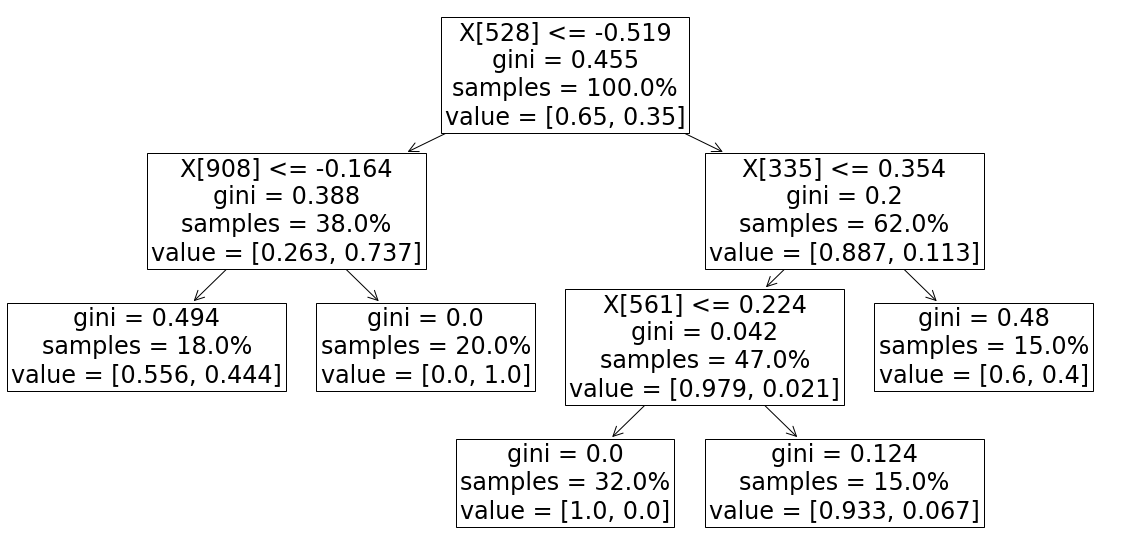

In [79]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, proportion=True) 

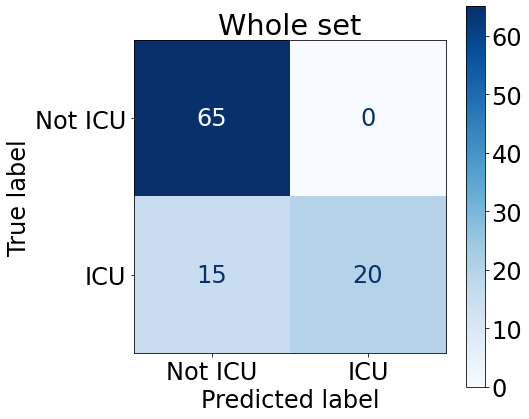

In [80]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 24})

disp = plot_confusion_matrix(clf, features, Y,
                             display_labels=['Not ICU','ICU'],
                             cmap=plt.cm.Blues,
                             ax=ax)
disp.ax_.set_title('Whole set')

label_font = {'size':'24'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);

### Cross-val

In [81]:
# cross-validation

from sklearn.model_selection import cross_val_score, cross_val_predict

cv_scores = cross_val_predict(clf, features, Y, cv=35)

print(confusion_matrix(Y, cv_scores))
print(classification_report(Y, cv_scores))

[[60  5]
 [16 19]]
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85        65
         1.0       0.79      0.54      0.64        35

    accuracy                           0.79       100
   macro avg       0.79      0.73      0.75       100
weighted avg       0.79      0.79      0.78       100



## Heatmap features

In [82]:
heatmaps_features_class1_path = "./output/1-2_icu_18feat_heatmap.csv"

heatmaps_features_class2_path = "./output/1-2_not_icu_18feat_heatmap.csv"

In [83]:
heatmaps_features_class1 = pd.read_csv(heatmaps_features_class1_path)
heatmaps_features_class1 = heatmaps_features_class1.iloc[:,1:].to_numpy()

print(heatmaps_features_class1.shape)

(35, 396)


In [84]:
heatmaps_features_class2 = pd.read_csv(heatmaps_features_class2_path)
heatmaps_features_class2 = heatmaps_features_class2.iloc[:,1:].to_numpy()

print(heatmaps_features_class2.shape)

(65, 396)


In [85]:
#concatenate
heatmaps_features = np.concatenate((heatmaps_features_class1, heatmaps_features_class2), axis=0)
print(heatmaps_features.shape)

#normalize
heatmaps_features_norm = (heatmaps_features - heatmaps_features.mean(axis=0)) / heatmaps_features.std(axis=0)  
print(heatmaps_features_norm.shape)

(100, 396)
(100, 396)


In [86]:
feature_name_heatmap_path = './output/features_names_heatmap.txt'

feature_names_heatmaps = []
with open(feature_name_heatmap_path,'r') as f:
    for line in f:
        feature_names_heatmaps.append(str(line))
        
print(len(feature_names_heatmaps))
print(feature_names_heatmaps[0:5])

396
['Atelectasis_whole_image_entropy\n', 'Atelectasis_whole_image_energy\n', 'Atelectasis_long1_entropy\n', 'Atelectasis_long1_energy\n', 'Atelectasis_long2_entropy\n']


In [87]:
features = heatmaps_features_norm
features_names_ = feature_names_heatmaps# feature_names_heatmaps

max_depth_tree = 3
min_samples_leaf = 20
clf = tree.DecisionTreeClassifier(class_weight={0:1,1:1},max_depth=max_depth_tree, min_samples_leaf=min_samples_leaf)

#class_weight={0:10,1:1}

in_training_loss = True
train_test_ratio = 0.2

if in_training_loss:
    clf = clf.fit(features, Y)
    y_pred = clf.predict(features)

    print(confusion_matrix(Y, y_pred))
    print(classification_report(Y, y_pred))

    feature_lst=[i for i in clf.tree_.feature if i != -2]

    print('features =', feature_lst)
    print('features name=', list(itemgetter(*feature_lst)(features_names_)))

else:
  X_train, X_test, y_train, y_test = \
  train_test_split(features, Y, test_size=train_test_ratio)

  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

[[53 12]
 [ 5 30]]
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86        65
         1.0       0.71      0.86      0.78        35

    accuracy                           0.83       100
   macro avg       0.81      0.84      0.82       100
weighted avg       0.84      0.83      0.83       100

features = [155, 226, 394]
features name= ['Fibrosis_whole_image_energy\n', 'Infiltration_trans1_entropy\n', 'Pneumothorax_quad6_entropy\n']


[Text(446.4, 475.65000000000003, 'X[155] <= -0.598\ngini = 0.455\nsamples = 100.0%\nvalue = [0.65, 0.35]'),
 Text(223.2, 339.75, 'gini = 0.298\nsamples = 22.0%\nvalue = [0.182, 0.818]'),
 Text(669.5999999999999, 339.75, 'X[226] <= 0.302\ngini = 0.341\nsamples = 78.0%\nvalue = [0.782, 0.218]'),
 Text(446.4, 203.85000000000002, 'X[394] <= -0.29\ngini = 0.158\nsamples = 58.0%\nvalue = [0.914, 0.086]'),
 Text(223.2, 67.94999999999999, 'gini = 0.34\nsamples = 23.0%\nvalue = [0.783, 0.217]'),
 Text(669.5999999999999, 67.94999999999999, 'gini = 0.0\nsamples = 35.0%\nvalue = [1.0, 0.0]'),
 Text(892.8, 203.85000000000002, 'gini = 0.48\nsamples = 20.0%\nvalue = [0.4, 0.6]')]

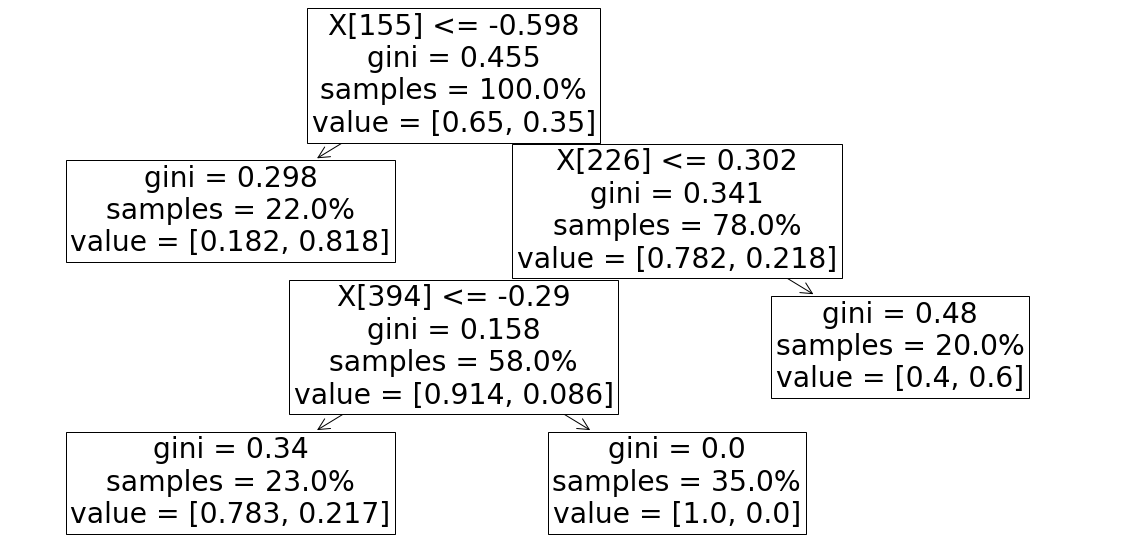

In [88]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, proportion=True) 

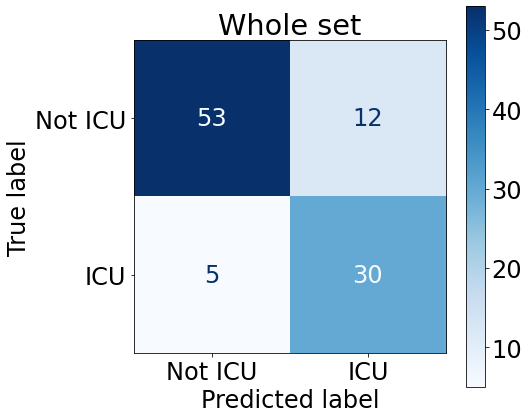

In [89]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 24})

disp = plot_confusion_matrix(clf, features, Y,
                             display_labels=['Not ICU','ICU'],
                             cmap=plt.cm.Blues,
                             ax=ax)
disp.ax_.set_title('Whole set')

label_font = {'size':'24'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);


### Cross-val

In [90]:
# cross-validation

from sklearn.model_selection import cross_val_score, cross_val_predict

cv_scores = cross_val_predict(clf, features, Y, cv=35)

print(confusion_matrix(Y, cv_scores))
print(classification_report(Y, cv_scores))

[[46 19]
 [13 22]]
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74        65
         1.0       0.54      0.63      0.58        35

    accuracy                           0.68       100
   macro avg       0.66      0.67      0.66       100
weighted avg       0.69      0.68      0.68       100



# BIMCV Pred

In [91]:
import pandas as pd

#metadata = pd.read_csv("../datasets/BIMCV-COVID19/BIMCV/derivatives/labels/labels_covid19_posi.tsv", sep='\t')
metadata = pd.read_csv("./output/bimcv_labels_covid19_posi.tsv", sep='\t')

In [92]:
data_test_name = "./output/bimcv_full_18feat.csv"

data_test = pd.read_csv(data_test_name)
data_test = data_test.iloc[:,1:].to_numpy()

print(data_test.shape)

(1312, 18)


In [93]:
data_test_norm = (data_test - data_test.mean(axis=0)) / data_test.std(axis=0)  
data_test_norm[np.isnan(data_test_norm)] = 0

In [103]:
#predict on test data

#RUN THE CLASSIFIER ON THE LAST LAYER FEATURES (FIRST SECTION) FIRST

y_pred = clf_18.predict(data_test_norm)

print('no_preds =', len(y_pred))
print('label 0 =', len([a for a in y_pred if a==0]))
print('label 1 =', len([a for a in y_pred if a==1]))

no_preds = 1312
label 0 = 694
label 1 = 618


In [104]:
output_pred_pth = './output/bim_predictions.txt'
output_pred_file = open(output_pred_pth,'w')


for y in y_pred:
    output_pred_file.write(str(int(y)))
    output_pred_file.write(',')
output_pred_file.close()

In [105]:
##ONLY EXECUTE WITH DATASET PRESENT

# list_of_imgs = os.listdir('../datasets/BIMCV-COVID19/BIMCV_processed/masked_filtered')

# output_features_names_pth = './output/bim_file_names.txt'
# file_features_names = open(output_features_names_pth,'w')


# for file_name in list_of_imgs:
#     file_features_names.write(file_name)
#     file_features_names.write(',')
# file_features_names.close()

In [106]:
# load name of files

file_name = 'bim_file_names.txt'

f = open(os.path.join('./output/',file_name), "r")
lst_of_files = f.read()
lst_of_files = lst_of_files.split(',')
lst_of_files = [i for i in lst_of_files[:-1]]

print('no of files =', len(lst_of_files))

no of files = 1312


In [107]:
# load predictions

file_name = 'bim_predictions.txt'

f = open(os.path.join('./output/',file_name), "r")
preds = f.read()
preds = preds.split(',')
preds = [int(i) for i in preds[:-1]]

print('no of predictions =', len(preds))

no of predictions = 1312


In [108]:
n_0 = len([a for a in preds if a==0])
n_1 = len([a for a in preds if a==1])

print('no_preds =', len(preds))
print('label 0 =', n_0)
print('label 1 =', n_1)

no_preds = 1312
label 0 = 694
label 1 = 618


In [109]:
#Get list with name of studies

pd.options.display.max_colwidth = 1000
lst_of_sess = []
for file_ in lst_of_files:
    idx = file_.find('ses-')
    lst_of_sess.append(file_[idx : idx+10])
    
column_ = 'Labels'#'Localizations'#

In [110]:
#Example of filtering the data

import re

a = metadata.loc[metadata['ReportID'] == lst_of_sess[25]][column_]
a = a.to_string()

print(a)

a = re.findall(r'\w+', a) 
a = [i for i in a if not i.isdigit()]
a = [i for i in a if i!='t']
#a = [i.replace('t','') for i in a]

print(a)

230    ['COVID 19'\t ' increased density']
['COVID', 'increased', 'density']


In [111]:
dic_1 = {}

for n in range(len(lst_of_sess)):
    
    if preds[n]==1:
        a = metadata.loc[metadata['ReportID'] == lst_of_sess[n]][column_]
        a = a.to_string() 
        
        a = re.findall(r'\w+', a) 
        a = [i for i in a if not i.isdigit()]
        a = [i for i in a if i!='t']
        #a = [i.replace('t','') for i in a]
        
        for word in a:
            if word not in list(dic_1.keys()):
                dic_1[word] = 0
            else:
                dic_1[word] += 1
                
    
    

In [112]:
sort_orders_dic_1 = sorted(dic_1.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders_dic_1:
    print(i[0], i[1] )

pattern 263
COVID 225
increased 168
density 168
pneumonia 159
unchanged 128
interstitial 120
infiltrates 97
alveolar 93
consolidation 84
normal 59
ground 48
glass 48
pleural 41
effusion 38
cardiomegaly 32
atelectasis 32
Series 30
aortic 29
tube 25
central 21
venous 20
catheter 20
laminar 19
costophrenic 17
angle 17
blunting 17
viral 17
elongation 15
atypical 14
changes 13
suboptimal 13
study 13
bronchovascular 13
markings 13
endotracheal 11
atheromatosis 10
via 9
vein 9
heart 9
exclude 9
hilar 8
enlargement 8
jugular 7
reticular 7
uncertain 7
vertebral 7
degenerative 7
thickening 6
chest 6
drain 6
pulmonary 6
chronic 5
insufficiency 5
apical 4
pseudonodule 4
NSG 4
air 3
bronchogram 3
artificial 3
valve 3
scoliosis 3
fracture 3
emphysema 3
hemidiaphragm 3
elevation 3
congestion 3
prosthesis 3
pneumothorax 3
mitral 2
descendent 2
pacemaker 2
diaphragmatic 2
eventration 2
rib 2
humeral 2
vascular 2
metal 2
material 2
hypertension 2
dai 2
NaN 2
calcified 2
mass 1
chamber 1
device 1
callus 

In [113]:
dic_0 = {}

for n in range(len(lst_of_sess)):
    
    if preds[n]==0:
        a = metadata.loc[metadata['ReportID'] == lst_of_sess[n]][column_]
        a = a.to_string() 
        
        a = re.findall(r'\w+', a) 
        a = [i for i in a if not i.isdigit()]
        a = [i for i in a if i!='t']
        #a = [i.replace('t','') for i in a]
        
        for word in a:
            if word not in list(dic_0.keys()):
                dic_0[word] = 0
            else:
                dic_0[word] += 1

    
                

In [114]:
sort_orders_dic_0 = sorted(dic_0.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders_dic_1:
    for p in sort_orders_dic_0:
        if i[0] == p[0]:
            print(p[0] , p[1])

# for i in sort_orders:
#     print(i[0], i[1])

pattern 204
COVID 218
increased 200
density 200
pneumonia 142
unchanged 144
interstitial 103
infiltrates 87
alveolar 58
consolidation 43
normal 109
ground 41
glass 41
pleural 26
effusion 22
cardiomegaly 29
atelectasis 23
Series 41
aortic 24
tube 5
central 9
venous 9
catheter 9
laminar 18
costophrenic 14
angle 14
blunting 14
viral 12
elongation 13
atypical 7
changes 12
suboptimal 8
study 8
bronchovascular 7
markings 7
endotracheal 3
atheromatosis 6
via 4
vein 4
heart 6
exclude 14
hilar 9
enlargement 9
jugular 2
reticular 7
uncertain 9
vertebral 11
degenerative 8
thickening 6
chest 0
drain 0
pulmonary 1
chronic 3
insufficiency 2
apical 3
pseudonodule 6
NSG 0
air 2
bronchogram 1
artificial 3
valve 3
scoliosis 0
fracture 0
emphysema 2
hemidiaphragm 3
elevation 3
congestion 0
prosthesis 1
pneumothorax 0
mitral 0
descendent 1
pacemaker 2
diaphragmatic 4
eventration 4
rib 0
vascular 3
metal 0
material 3
hypertension 0
dai 5
NaN 3
calcified 3
mass 0
chamber 2
device 2
callus 0
subcutaneous 0
g

In [115]:
for i in sort_orders_dic_1:
    for p in sort_orders_dic_0:
        if i[0] == p[0]:
            if p[1] !=0:
                print(p[0], (i[1]/n_1)/(p[1]/n_0))

pattern 1.4477600101529284
COVID 1.1590362518927584
increased 0.9433009708737864
density 0.9433009708737864
pneumonia 1.257418296184876
unchanged 0.9982020855807264
interstitial 1.308323121877651
infiltrates 1.2520552021723765
alveolar 1.8006360897221292
consolidation 2.193723188078573
normal 0.6078501232148689
ground 1.3147051858868102
glass 1.3147051858868102
pleural 1.7708488922081156
effusion 1.9396881435716387
cardiomegaly 1.2391474165829708
atelectasis 1.562403264387224
Series 0.8216907411792564
aortic 1.3569309600862998
tube 5.614886731391586
central 2.6202804746494066
venous 2.4955052139518155
catheter 2.4955052139518155
laminar 1.1853649766271126
costophrenic 1.3636153490522422
angle 1.3636153490522422
blunting 1.3636153490522422
viral 1.5908845738942825
elongation 1.2957430918595967
atypical 2.2459546925566345
changes 1.2165587918015102
suboptimal 1.8248381877022655
study 1.8248381877022655
bronchovascular 2.0855293573740177
markings 2.0855293573740177
endotracheal 4.11758360